In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from efficientnet.tfkeras import EfficientNetB0
import math
import random
import cv2
import skimage.io
import glob
import os
import functools
from albumentations import *
from sklearn import model_selection, metrics
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm


from config import Config
from util import get_optimizer, DataManager
from generator import get_dataset
from model import NeuralNet, fit, predict


tf.config.set_visible_devices([], 'GPU')

### Visualization of current data generator

x shape = (2, 1536, 1536, 3)


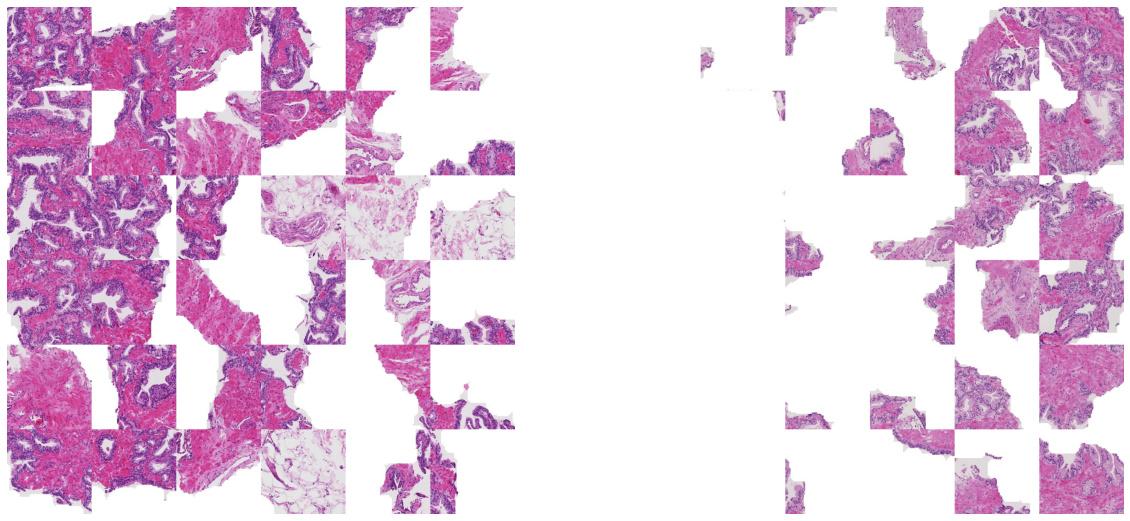

In [2]:
data = DataManager.get_train_file()

dataset = get_dataset(
    dataframe=data, 
    input_path=Config.input.path,
    batch_size=Config.train.batch_size,
    training=True,
    augment=True,
    buffer_size=1,
    cache=False,
)

for x,y in dataset.take(1):
    x = x.numpy()
    print("x shape =", x.shape)

fig, axes = plt.subplots(1, Config.train.batch_size, figsize=(20, 20))

if Config.train.batch_size > 1:
    for i, ax in enumerate(axes.reshape(-1)):
        ax.imshow(x[i])
        ax.axis('off')
else:
    axes.imshow(x[0])
    axes.axis('off')

### experimental

In [3]:
import tensorflow as tf
import numpy as np
import pandas as pd
import cv2
import skimage.io
import glob
import os
from albumentations import *

from config import Config


def run(Config):
    def map_decorator(func):
        def wrapper(*args):
            return tf.py_function(
                func=func,
                inp=[*args],
                Tout=[tf.uint8, tf.int32]
            )
        return wrapper

    augmentor = (
        Compose([
          RandomRotate90(
              p=0.5),
          Flip(
              p=0.5),
          Transpose(
              p=0.5),
       ])
    )

    @map_decorator
    def augmentation(image, label):
        image = augmentor(image=image.numpy())['image']
        return image, label

    if Config.input.tiff_format:
        def _crop_white(image):
            value = 255
            assert image.shape[2] == 3
            assert image.dtype == np.uint8
            ys, = (image.min((1, 2)) < value).nonzero()
            xs, = (image.min(0).min(1) < value).nonzero()
            if len(xs) == 0 or len(ys) == 0:
                return image
            image = image[ys.min():ys.max() + 1, xs.min():xs.max() + 1]
            del ys
            del xs
            return image

        @map_decorator
        def read_image(image_path, label, resize_ratio=Config.input.resize_ratio):
            image_path = image_path.numpy().decode('utf-8')
            image = skimage.io.MultiImage(image_path + '.tiff')
            image = image[0]
            image = _crop_white(image)
            if resize_ratio != 1:
                new_w = int(image.shape[1]*resize_ratio)
                new_h = int(image.shape[0]*resize_ratio)
                image = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_AREA)
            return image, label
    else:
        @map_decorator
        def read_image(image_path, label, resize_ratio=Config.input.resize_ratio):
            image_path = image_path.numpy().decode('utf-8')
            image = cv2.imread(image_path + '.jpeg')
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            if resize_ratio != 1:
                new_w = int(image.shape[1]*resize_ratio)
                new_h = int(image.shape[0]*resize_ratio)
                image = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_AREA)
            return image, label

    @tf.function
    def compute_patches(image, label, ps=Config.input.patch_size, ss=Config.input.sample_size):
        """Computes patches to be used as input to the Neural Network.
        If number of patches exceeds the sample_size (ss), the
        patches with most information are selected"""
        image_shape = tf.shape(image)
        h, w = tf.gather(image_shape, 0), tf.gather(image_shape, 1)
        pad_h = (ps - h % ps)
        pad_w = (ps - w % ps)

        pu = tf.random.uniform(shape=(), minval=0, maxval=pad_h, dtype=tf.int32)
        pd = pad_h - pu
        pl = tf.random.uniform(shape=(), minval=0, maxval=pad_w, dtype=tf.int32)
        pr = pad_w - pl

        image = tf.pad(
            image, ((pu, pd), (pl, pr), (0, 0)), constant_values=255)

        image_shape = tf.shape(image)
        h, w = tf.gather(image_shape, 0), tf.gather(image_shape, 1)

        image = tf.reshape(image, (h//ps, ps, w//ps, ps, 3))
        image = tf.transpose(image, (0, 2, 1, 3, 4))
        image = tf.reshape(image, (-1, ps, ps, 3))

        num_images = tf.gather(tf.shape(image), 0)

        info = tf.reduce_sum(tf.cast(tf.reshape(image, (num_images, -1)), tf.int32), 1)

        if tf.gather(tf.shape(info), 0) < ss:

            image = tf.pad(
                image, ((0, ss-num_images), (0, 0), (0, 0), (0, 0)), constant_values=255)

            paddings = tf.zeros(ss-num_images, dtype=tf.int32)+(ps**2*3*255)
            info = tf.concat((info, paddings), axis=0)

        indices = tf.gather(tf.argsort(info), tf.range(ss))
        image = tf.gather(image, indices)
        return image, label

    def _patch_augment(patch):
        """Performs random rotation, random flip (u/d, l/r),
        and random transpose, based on probability p"""
        p = 0.5
        r1 = tf.random.uniform(
            shape=(4,), minval=0, maxval=1)
        r2 = tf.random.uniform(
            shape=(), minval=0, maxval=4, dtype=tf.int32)
        if r1[0] > (1-p):
            patch = tf.image.rot90(patch, k=r2)
        if r1[1] > (1-p):
            patch = tf.image.random_flip_left_right(patch)
        if r1[2] > (1-p):
            patch = tf.image.random_flip_up_down(patch)
        if r1[3] > (1-p):
            patch = tf.transpose(patch, (1, 0, 2))
        return patch

    @tf.function
    def stitch_patches(patches, label, ps=Config.input.patch_size, l=int(np.sqrt(Config.input.sample_size))):
        """Stitches together patches into one single
        big image, with augmentation on patch-level"""
        image = tf.zeros([0, ps, ps, 3], dtype=tf.uint8)
        for i in range(len(patches)):
            _patch = _patch_augment(tf.gather(patches, i))
            image = tf.concat((
                image, tf.expand_dims(_patch, 0)
            ), axis=0)
        image = tf.reshape(image, (-1, ps*l, ps, 3))
        image = tf.transpose(image, (0, 2, 1, 3))
        image = tf.reshape(image, (ps*l, ps*l, 3))
        return image, label

    @tf.function
    def preprocess_input(x, y, mode=Config.input.preprocess_mode):
        x = tf.cast(x, dtype=tf.dtypes.float32)
        y = tf.cast(y, dtype=tf.dtypes.float32)
        if mode == 'tf':
            x /= 127.5
            x -= 1.
            return x, y
        elif mode == 'torch':
            x /= 255.
            mean = tf.constant([0.485, 0.456, 0.406], dtype=tf.float32)
            std = tf.constant([0.229, 0.224, 0.225], dtype=tf.float32)
            x -= mean
            x /= std
            return x, y
        elif mode == 'caffe':
            mean = tf.constant([103.939, 116.779, 123.68], dtype=tf.float32)
            x -= mean
            return x, y
        elif mode == 'float':
            x /= 255.
            return x, y
        else:
            return x, y

    def get_dataset(dataframe, input_path, batch_size, training,
                    augment, buffer_size=1, cache=False):
        if cache:
            if not(os.path.isdir('tmp/')):
                os.mkdir('tmp')
            else:
                files = glob.glob(f'tmp/*')
                for f in files:
                    os.remove(f)
            if training:
                cache_path = 'tmp/cache_train'
            else:
                cache_path = 'tmp/cache_infer'

        image_paths = (input_path + dataframe.image_id).values.astype(str)
        labels = np.zeros((len(dataframe), 5), dtype=np.int32)
        for i, label in enumerate(dataframe.isup_grade):
            labels[i, :label] = 1.

        dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
        dataset = dataset.shuffle(buffer_size)
        dataset = dataset.map(read_image, tf.data.experimental.AUTOTUNE)
        dataset = dataset.map(compute_patches, tf.data.experimental.AUTOTUNE)
        dataset = dataset.map(stitch_patches, tf.data.experimental.AUTOTUNE)

        if cache:
            dataset = dataset.cache(cache_path)

        if augment:
            dataset = dataset.map(augmentation, tf.data.experimental.AUTOTUNE)

        dataset = dataset.map(preprocess_input, tf.data.experimental.AUTOTUNE)
        dataset = dataset.batch(batch_size)
        dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

        return dataset
    
    return get_dataset

Input size = 1536.0
x shape = (2, 1536, 1536, 3)


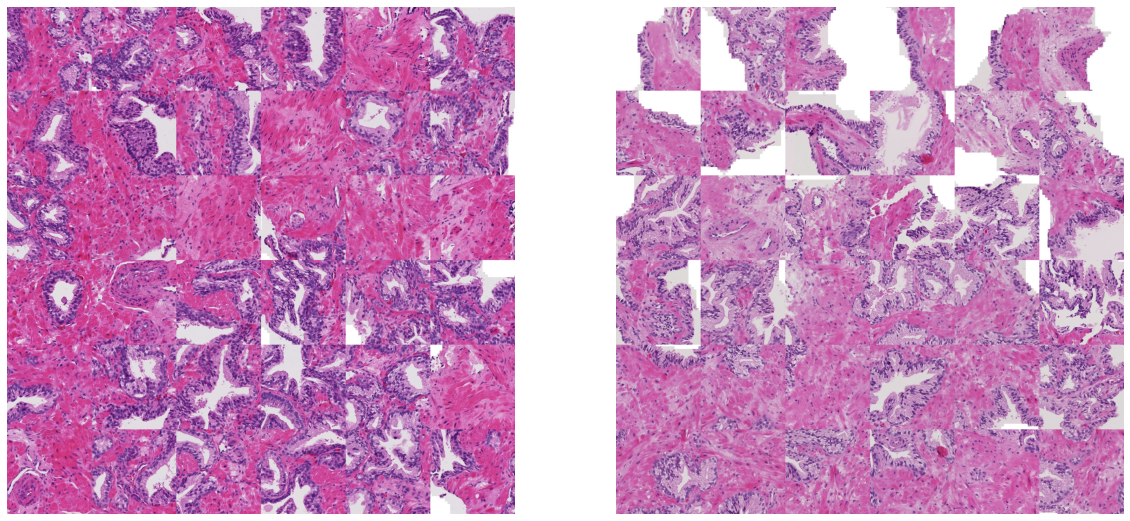

In [13]:
Config.input.path = Config.input.path[:-2] + "0/"
Config.input.patch_size = 256
Config.input.sample_size = 6*6
Config.input.preprocess_mode = 'float'

print("Input size =", Config.input.patch_size * np.sqrt(Config.input.sample_size))

get_dataset = run(Config)

dataset = get_dataset(
    dataframe=data, 
    input_path=Config.input.path,
    batch_size=Config.train.batch_size,
    training=True,
    augment=True,
    buffer_size=1,
    cache=False,
)

for x,y in dataset.take(1):
    x = x.numpy()
    print("x shape =", x.shape)

fig, axes = plt.subplots(1, Config.train.batch_size, figsize=(20, 20))

if Config.train.batch_size > 1:
    for i, ax in enumerate(axes.reshape(-1)):
        ax.imshow(x[i])
        ax.axis('off')
else:
    axes.imshow(x[0])
    axes.axis('off')

In [12]:
Config.input.path 

'../input/prostate-cancer-grade-assessment/train_images_jpeg_10'